# Import package. Core package: sklearn, scipy

In [1]:
import pandas as pd
import datetime as dt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

In [2]:
from sklearn.base import BaseEstimator
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.optimize import differential_evolution

In [3]:
import HP_function as HP

## Investment Assets 
## 需要投资的大类资产，当前使用：十年期国债收益率，沪深300指数，南华期货综合指数（大宗商品） 

In [4]:
Bond = pd.read_excel('YTM.xlsx',parse_dates = ['Date']) #Treasury Bond yield
Bond['Month'] = Bond['Date'].dt.to_period('M') # extract Month
#Bond.set_index('Month',inplace = True)
Bond

,Date,YTM1Y,YTM5Y,YTM10Y,YTM30Y,Month
0,2025-03-31,1.5412,1.6537,1.8101,2.0231,2025-03
1,2025-03-28,1.5233,1.6579,1.8122,2.0251,2025-03
2,2025-03-27,1.5254,1.6567,1.8063,2.0101,2025-03
3,2025-03-26,1.5274,1.6548,1.7958,2.0001,2025-03
4,2025-03-25,1.5429,1.6777,1.8238,2.0261,2025-03
...,...,...,...,...,...,...
4176,2008-07-07,3.4796,4.2140,4.5527,4.9404,2008-07
4177,2008-07-04,3.4763,4.2209,4.5542,4.9501,2008-07
4178,2008-07-03,3.4972,4.2350,4.5356,4.9501,2008-07
4179,2008-07-02,3.5461,4.2260,4.5291,4.9501,2008-07


In [5]:
# YTM -> Capital gain 根据收益率数据计算资本利得（麦考利久期 MacD = 8.5）
Bond_10 = Bond.groupby('Month')['YTM10Y'].apply(lambda x: round((x.iloc[0]-x.iloc[-1])/100*(-8.8),4))
# ΔP(%) = -(MacD/1+y)*Δy = -MD*Δy
# Δy 月末利率减去月初利率
Bond_10 = Bond_10.to_frame(name = 'Bond10')
Bond_10.reset_index(inplace = True)
Bond_10['Date'] = Bond_10['Month'].dt.to_timestamp()+pd.offsets.MonthEnd(0) #调整一下时间方便后续合并Dataframe
Bond_10.drop(columns = ['Month'],inplace = True)
Bond_10

,Bond10,Date
0,-0.0006,2008-07-31
1,0.0228,2008-08-31
2,0.0392,2008-09-30
3,0.0574,2008-10-31
4,0.0109,2008-11-30
...,...,...
196,0.0105,2024-11-30
197,0.0264,2024-12-31
198,-0.0016,2025-01-31
199,-0.0086,2025-02-28


In [6]:
#大宗商品/股指的收益率计算比较简单 (P1-P0)/P0
Commodity =pd.read_excel('Commodity.xlsx',parse_dates = ['Date']) 
Commodity['Month'] = Commodity['Date'].dt.to_period('M')
Future = Commodity.groupby('Month')['Commodity'].apply(lambda x: round((x.iloc[-1]-x.iloc[0])/x.iloc[0],4))
Future = Future.to_frame(name = 'Commodity')
Future.reset_index(inplace = True)
Future['Date'] = Future['Month'].dt.to_timestamp()+pd.offsets.MonthEnd(0)
Future.drop(columns = ['Month'],inplace = True)
Future

,Commodity,Date
0,0.0071,2004-06-30
1,-0.0514,2004-07-31
2,0.0160,2004-08-31
3,0.0188,2004-09-30
4,-0.0490,2004-10-31
...,...,...
246,-0.0100,2024-12-31
247,0.0240,2025-01-31
248,-0.0054,2025-02-28
249,-0.0050,2025-03-31


In [7]:
HS300 = pd.read_excel('HS300.xlsx',parse_dates = ['Date'])
HS300['Month'] = HS300['Date'].dt.to_period('M')
Stock = HS300.groupby('Month')['HS300'].apply(lambda x: round((x.iloc[0]-x.iloc[-1])/x.iloc[-1],4))
Stock = Stock.to_frame(name = 'Stock')
Stock.reset_index(inplace = True)
Stock['Date'] = Stock['Month'].dt.to_timestamp()+pd.offsets.MonthEnd(0)
Stock.drop(columns = ['Month'],inplace = True)
Stock

,Stock,Date
0,-0.0719,2002-01-31
1,0.0237,2002-02-28
2,0.0703,2002-03-31
3,0.0273,2002-04-30
4,-0.0773,2002-05-31
...,...,...
275,-0.0032,2024-12-31
276,-0.0009,2025-01-31
277,0.0250,2025-02-28
278,-0.0003,2025-03-31


In [8]:
#合并三个大类资产数据
Asset_yield = pd.merge(Bond_10,Stock,how = 'left', on = ['Date'])
Asset_yield = pd.merge(Asset_yield,Future,how = 'left', on = ['Date'])
Asset_yield.set_index(['Date'],inplace = True)
Asset_yield = Asset_yield['2016-01-31':'2024-12-31']
#Asset_yield['None'] = 0  No poisition #是否加入空仓选项
Asset_yield

,Bond10,Stock,Commodity
Date,,,
2016-01-31,-0.0019,-0.1508,0.0066
2016-02-29,-0.0018,-0.0081,0.0360
2016-03-31,0.0017,0.0981,0.0464
2016-04-30,-0.0026,-0.0202,0.1094
2016-05-31,-0.0077,-0.0137,-0.0876
...,...,...,...
2024-08-31,-0.0036,-0.0286,-0.0201
2024-09-30,-0.0003,0.2306,0.0736
2024-10-31,0.0044,-0.0858,-0.0103


In [9]:
# 将数据转化为矩阵（数组 array）
arr_asset = Asset_yield.values

In [10]:
Dimensions = ['Growth','Inflation','Spread','Monetary','Foreign']

In [17]:
Growth = pd.read_excel('MacroFactor.xlsx',sheet_name = 'Growth',parse_dates=['Date'])
Growth = Growth.replace (0,np.nan)
Growth = Growth[(Growth['Date'] < dt.datetime(2025,6,1)) & (Growth['Date'] > dt.datetime(2015,11,1))]
Growth = Growth.fillna(method = 'bfill')
Growth

,Date,工业增加值,制造业PMI,OECD领先指标,商品房销售面积,社会消费品零售,房地产开发投资
71,2015-11-30,6.200000,49.6,99.86100,7.4,11.1722,1.3
72,2015-12-31,5.900000,49.7,99.79388,6.5,11.1000,1.0
73,2016-01-31,5.865724,49.4,99.73154,28.2,10.2000,3.0
74,2016-02-29,4.906937,49.0,99.68845,28.2,10.2000,3.0
75,2016-03-31,6.800000,50.2,99.66988,33.1,10.5000,6.2
...,...,...,...,...,...,...,...
180,2024-12-31,6.200000,50.1,99.74623,-12.9,3.7000,-10.6
181,2025-01-31,-11.110000,49.1,100.00940,-5.1,4.0000,-9.8
182,2025-02-28,31.020000,50.2,100.27240,-5.1,4.0000,-9.8
183,2025-03-31,7.700000,50.5,100.52760,-3.0,5.9000,-9.9


In [18]:
Inflation = pd.read_excel('MacroFactor.xlsx',sheet_name = 'Inflation',parse_dates=['Date'])
Inflation = Inflation.replace (0,np.nan)
Inflation = Inflation[(Inflation['Date'] < dt.datetime(2025,6,1)) & (Inflation['Date'] > dt.datetime(2015,11,1))]
Inflation = Inflation.fillna(method = 'ffill')
Inflation

,Date,PPI同比,CPI同比,CPI非食品同比
71,2015-11-30,-5.9,1.485600,1.0647
72,2015-12-31,-5.9,1.600000,1.1000
73,2016-01-31,-5.3,1.800000,1.2000
74,2016-02-29,-4.9,2.300000,1.0000
75,2016-03-31,-4.3,2.301391,1.0000
...,...,...,...,...
179,2024-11-30,-2.5,0.200000,-0.3000
180,2024-12-31,-2.3,0.100000,0.2000
181,2025-01-31,-2.3,0.500000,0.5000
182,2025-02-28,-2.2,-0.700000,-0.1000


In [19]:
Spread = pd.read_excel('MacroFactor.xlsx',sheet_name = 'Spread',parse_dates=['Date'])
Spread = Spread.replace (0,np.nan)
Spread = Spread[(Spread['Date'] < dt.datetime(2025,6,1)) & (Spread['Date'] > dt.datetime(2015,11,1))]
Spread = Spread.fillna(method = 'bfill')
Spread

,Date,期限利差,信用利差
71,2015-11-30,0.588995,0.614043
72,2015-12-31,0.511891,0.720226
73,2016-01-31,0.498235,0.969595
74,2016-02-29,0.556918,1.404575
75,2016-03-31,0.721739,1.203096
...,...,...,...
181,2025-01-31,0.432937,0.652444
182,2025-02-28,0.302642,0.609528
183,2025-03-31,0.278752,0.570224
184,2025-04-30,0.217523,0.521405


In [20]:
Monetary = pd.read_excel('MacroFactor.xlsx',sheet_name = 'Monetary',parse_dates=['Date'])
Monetary = Monetary.replace (0,np.nan)
Monetary = Monetary[(Monetary['Date'] < dt.datetime(2025,6,1)) & (Monetary['Date'] > dt.datetime(2015,11,1))]
Monetary = Monetary.fillna(method = 'bfill')
Monetary

,Date,社融同比,M1同比,M2同比,金融机构贷款余额同比
71,2015-11-30,12.4,15.7,13.7,14.9
72,2015-12-31,12.4,15.2,13.3,14.3
73,2016-01-31,13.1,18.6,14.0,15.3
74,2016-02-29,12.7,17.4,13.3,14.7
75,2016-03-31,13.4,22.1,13.4,14.7
...,...,...,...,...,...
179,2024-11-30,7.8,-0.7,7.1,7.7
180,2024-12-31,8.0,1.2,7.3,7.6
181,2025-01-31,8.0,0.4,7.0,7.5
182,2025-02-28,8.2,0.1,7.0,7.3


In [21]:
Foreign = pd.read_excel('MacroFactor.xlsx',sheet_name = 'Foreign',parse_dates=['Date'])
Foreign = Foreign.replace (0,np.nan)
Foreign = Foreign[(Foreign['Date'] < dt.datetime(2025,6,1)) & (Foreign['Date'] > dt.datetime(2015,11,1))]
Foreign = Foreign.fillna(method = 'bfill')
Foreign

,Date,美元指数,10年期美国国债收益率
71,2015-11-30,99.064948,2.263158
72,2015-12-31,98.342048,2.242727
73,2016-01-31,99.010535,2.085263
74,2016-02-29,97.082881,1.779500
75,2016-03-31,96.269891,1.889091
...,...,...,...
181,2025-01-31,108.584209,4.629048
182,2025-02-28,107.313230,4.451053
183,2025-03-31,104.124319,4.280476
184,2025-04-30,100.661750,4.279048


In [44]:
Macrofactor = pd.merge(Growth,Inflation, on = 'Date', how = 'inner')
Macrofactor = Macrofactor.merge(Spread, on = 'Date', how = 'inner')
Macrofactor = Macrofactor.merge(Monetary, on = 'Date', how = 'inner')
Macrofactor = Macrofactor.merge(Foreign, on = 'Date', how = 'inner')
Macrofactor.set_index('Date',inplace = True)

#由于宏观指标有滞后性因此，2015-11-30对饮计算的时间是2016年01月的大类资产的表现
trainfactor = Macrofactor.iloc[:108] #训练时间2016-01-01 --- 2024-12-31

trainfactor

,工业增加值,制造业PMI,OECD领先指标,商品房销售面积,社会消费品零售,房地产开发投资,PPI同比,CPI同比,CPI非食品同比,期限利差,信用利差,社融同比,M1同比,M2同比,金融机构贷款余额同比,美元指数,10年期美国国债收益率
Date,,,,,,,,,,,,,,,,,
2015-11-30,6.200000,49.6,99.86100,7.4,11.1722,1.3,-5.9,1.485600,1.0647,0.588995,0.614043,12.4,15.7,13.7,14.9,99.064948,2.263158
2015-12-31,5.900000,49.7,99.79388,6.5,11.1000,1.0,-5.9,1.600000,1.1000,0.511891,0.720226,12.4,15.2,13.3,14.3,98.342048,2.242727
2016-01-31,5.865724,49.4,99.73154,28.2,10.2000,3.0,-5.3,1.800000,1.2000,0.498235,0.969595,13.1,18.6,14.0,15.3,99.010535,2.085263
2016-02-29,4.906937,49.0,99.68845,28.2,10.2000,3.0,-4.9,2.300000,1.0000,0.556918,1.404575,12.7,17.4,13.3,14.7,97.082881,1.779500
2016-03-31,6.800000,50.2,99.66988,33.1,10.5000,6.2,-4.3,2.301391,1.0000,0.721739,1.203096,13.4,22.1,13.4,14.7,96.269891,1.889091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30,5.300000,49.5,99.15972,-19.0,2.0000,-10.1,-0.8,0.200000,0.8000,0.661611,0.369063,8.1,-1.7,6.2,8.8,105.186200,4.305263
2024-07-31,5.100000,49.4,99.04798,-18.6,2.7000,-10.2,-0.8,0.500000,0.7000,0.725561,0.389726,8.2,-2.6,6.3,8.7,104.620426,4.248636
2024-08-31,4.500000,49.1,99.02336,-18.0,2.1000,-10.2,-1.8,0.600000,0.2000,0.689773,0.427841,8.1,-3.0,6.3,8.5,102.216155,3.870909


## 以下是对数据进行操作和平滑的工具

In [45]:
#滤波
def HPfilter(series, lamb = 10):
    cycle,trend = sm.tsa.filters.hpfilter(series, lamb)
    return trend

In [46]:
#正态化
def Normalization(series):
    se_mean = series.mean()
    se_std = series.std()
    return (series - se_mean)/se_std

In [47]:
#卷积（可以简单理解为带权重的移动平均线）
def convolved(series,decay_factor:int,n_day):
    #data: import dataframe; idx: analysis column; decay_factor:[0,1], Moving average parameter; n_day: Moving average for n days 
    if 0<=decay_factor<1:
        w1 = (1-decay_factor)/(1-decay_factor**n_day) # solve for weight 1
    elif v==1:
        w1 = 1/n_day #special case for decay factor equals 1
    else:
        print("请检查衰退因子输入是否有误")
        return None
    kernel = w1*decay_factor**np.arange(n_day)  # convolution kernel which is a geometric progression
    convolved_signal = np.convolve(series, kernel, mode='vaild') #convolution
    return series

In [48]:
#df = df.apply(HPfilter)
trainfactor = trainfactor.apply(lambda x: convolved(x,0.9,12))
trainfactor = trainfactor.apply(Normalization)
trainfactor

,工业增加值,制造业PMI,OECD领先指标,商品房销售面积,社会消费品零售,房地产开发投资,PPI同比,CPI同比,CPI非食品同比,期限利差,信用利差,社融同比,M1同比,M2同比,金融机构贷款余额同比,美元指数,10年期美国国债收益率
Date,,,,,,,,,,,,,,,,,
2015-11-30,0.050832,-0.336532,0.135141,0.176463,0.575623,-0.216656,-1.601355,-0.124641,-0.291827,-0.118435,-0.967567,0.464236,1.098631,2.210895,1.879561,0.191950,-0.203102
2015-12-31,0.008820,-0.279743,0.099088,0.137410,0.566503,-0.246655,-1.601355,-0.028917,-0.250586,-0.506769,-0.672293,0.464236,1.028975,1.986481,1.455924,0.044984,-0.222172
2016-01-31,0.004020,-0.450112,0.065603,1.079028,0.452827,-0.046664,-1.470533,0.138434,-0.133756,-0.575549,0.021149,0.812795,1.502636,2.379206,2.161985,0.180887,-0.369150
2016-02-29,-0.130250,-0.677271,0.042458,1.079028,0.452827,-0.046664,-1.383318,0.556810,-0.367416,-0.279994,1.230737,0.613619,1.335461,1.986481,1.738349,-0.211005,-0.654551
2016-03-31,0.134857,0.004207,0.032483,1.291651,0.490719,0.273320,-1.252497,0.557974,-0.367416,0.550129,0.670465,0.962178,1.990228,2.042585,1.738349,-0.376286,-0.552258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30,-0.075205,-0.393322,-0.241544,-0.969100,-0.582894,-1.356601,-0.489370,-1.200370,-0.601076,0.247292,-1.648804,-1.676915,-1.325400,-1.996871,-2.427412,1.436401,1.703012
2024-07-31,-0.103213,-0.450112,-0.301564,-0.951743,-0.494479,-1.366600,-0.489370,-0.949344,-0.717906,0.569378,-1.591345,-1.627121,-1.450781,-1.940767,-2.498018,1.321379,1.650156
2024-08-31,-0.187238,-0.620482,-0.314789,-0.925708,-0.570264,-1.366600,-0.707406,-0.865669,-1.302055,0.389131,-1.485355,-1.676915,-1.506506,-1.940767,-2.639230,0.832590,1.297583


In [49]:
#变为矩阵
arr_factor = trainfactor.values

In [50]:
#核心 机器学习代码
class ListMLE(BaseEstimator):
    def __init__(self):
        self.weights = None

    def fit(self,X,y):
        self.n_features = X.shape[1]
        self.n_queries = y.shape[1]
        self.weights = np.ones((self.n_features, self.n_queries))

        def loss(weights):
            weights_matrix = weights.reshape((self.n_features, self.n_queries))
            scores = np.dot(X,weights_matrix)
            sorted_indices = np.argsort(y)
            loss_value = 0
            
            #损失函数定义 ListMLE 方法
            for i in range(0,len(y)):
                y_rank =  sorted_indices[i]
                score_slice = scores[i]
                loss_discrete = 0
                numerator = [score_slice[rank] for rank in y_rank] 
                dinominator = np.log(np.exp(numerator).cumsum())
                loss_discrete += np.sum(numerator-dinominator)
                loss_value += loss_discrete
            return -loss_value

        initial_weights = self.weights.flatten() #将参数矩阵进行平展化
        #bounds = [(-10,10) for _ in range(X.shape[1]*y.shape[1])]
        #result = basinhopping(loss, initial_weights)
        #result = differential_evolution(lambda initial_weights: loss(initial_weights),bounds)
        result = minimize(loss, initial_weights, method='BFGS')
        self.weights = result.x.reshape((self.n_features, self.n_queries))

    def predict(self, X):
        return np.dot(X, self.weights)

In [51]:
# 创建和训练 ListMLE 模型
model = ListMLE()
model.fit(arr_factor, arr_asset)

# 预测
#打分之后分数最高的是当月的投资资产
print(model.weights)
predictions = model.predict(arr_factor)
print("预测结果:", predictions)

[[1.24130323 0.67533584 1.08337259]
 [1.31141599 0.73704969 0.95151392]
 [1.0405718  0.96666874 0.99273237]
 [1.32812537 0.40422196 1.2676196 ]
 [0.59875372 1.25971968 1.14153763]
 [1.12662692 1.24117566 0.63215957]
 [1.09954443 1.32137299 0.57906967]
 [1.4595533  0.79488509 0.7455306 ]
 [0.80560798 0.56502323 1.62938833]
 [0.9028502  1.2308519  0.86630167]
 [0.59687104 1.32028967 1.08282507]
 [1.06471872 1.22814036 0.70716995]
 [0.95249433 1.34899936 0.69851904]
 [1.262492   0.66118158 1.07632159]
 [0.66494977 1.28868332 1.04637057]
 [0.37447139 1.42831088 1.19722077]
 [1.85739304 0.80224524 0.34036926]]
预测结果: [[  2.51150876   2.68866103   3.56954618]
 [  1.68194462   1.6005542    2.66935602]
 [  5.22505286   5.44060513   6.59278355]
 [  4.41784489   5.37226091   6.06577292]
 [  8.05015192   8.22504926   8.29684528]
 [  7.45410729   7.24344824   7.38721067]
 [  5.75511498   6.10676776   6.04448384]
 [  4.51942303   4.9320057    5.06962827]
 [  2.12110717   2.75008868   2.98899616]
 [ 

In [52]:
a = np.argsort(-predictions) #排名函数：第一列是每行值最小的索引位置，加负号之后，第一列是值最大的每行值最小的索引位置
a #投资的时候投第一列代表的资产就行

array([[2, 1, 0],
       [2, 0, 1],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [0, 2, 1],
       [1, 2, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 0, 1],
       [2, 0, 1],
       [0, 1, 2],
       [1, 2, 0],
       [1, 0, 2],
       [1, 2, 0],
       [1, 2, 0],
       [1, 2, 0],
       [1, 2, 0],
       [1, 2, 0],
       [1, 0, 2],
       [1, 0, 2],
       [0, 1, 2],
       [0, 1, 2],
       [1, 2, 0],
       [1, 2, 0],
       [1, 0, 2],
       [1, 0, 2],
       [0, 1, 2],
       [0, 1, 2],
       [1, 0, 2],
       [1, 0, 2],
       [2, 0, 1],
       [0, 2, 1],
       [0, 1, 2],
       [0, 2, 1],
       [1, 2, 0],
       [1, 2, 0],
       [1, 2, 0],
       [1, 2, 0],
       [1, 2, 0],
       [1, 2, 0],
       [1, 2, 0],
       [1, 2, 0],
       [1, 2, 0],
       [2, 1, 0],
       [2, 1, 0],
       [1, 2, 0],
       [0, 2, 1],
       [0, 2, 1],
       [0, 2, 1],
       [1, 2, 0],
       [0, 1, 2],
       [1, 2, 0],
       [1, 2, 0],
       [1,

In [53]:
i = 0
pv = 100
lst = []
for num in a[:,0]:
    r = arr_asset[i,num]
    i += 1
    pv *= (1+r)
    lst.append(pv)
pv

317.10921826259704

In [54]:
(pv/100)**(1/9)

1.1368152061215382

In [55]:
months = pd.date_range(start="2016-01-01", periods=108, freq="M")

In [56]:
df = pd.DataFrame(a[:,0], index=months, columns=['Value'])
dic = {0:'债',1:'股',2:'商',3:'空仓'}
df['asset'] = df['Value'].map(dic)
df.to_excel('Model result.xlsx')
df

,Value,asset
2016-01-31,2,商
2016-02-29,2,商
2016-03-31,2,商
2016-04-30,2,商
2016-05-31,2,商
...,...,...
2024-08-31,0,债
2024-09-30,0,债
2024-10-31,0,债
2024-11-30,0,债


In [57]:
for i in range (0,len(df)):
    print(df.iloc[i])

Value    2
asset    商
Name: 2016-01-31 00:00:00, dtype: object
Value    2
asset    商
Name: 2016-02-29 00:00:00, dtype: object
Value    2
asset    商
Name: 2016-03-31 00:00:00, dtype: object
Value    2
asset    商
Name: 2016-04-30 00:00:00, dtype: object
Value    2
asset    商
Name: 2016-05-31 00:00:00, dtype: object
Value    0
asset    债
Name: 2016-06-30 00:00:00, dtype: object
Value    1
asset    股
Name: 2016-07-31 00:00:00, dtype: object
Value    2
asset    商
Name: 2016-08-31 00:00:00, dtype: object
Value    2
asset    商
Name: 2016-09-30 00:00:00, dtype: object
Value    2
asset    商
Name: 2016-10-31 00:00:00, dtype: object
Value    2
asset    商
Name: 2016-11-30 00:00:00, dtype: object
Value    2
asset    商
Name: 2016-12-31 00:00:00, dtype: object
Value    0
asset    债
Name: 2017-01-31 00:00:00, dtype: object
Value    1
asset    股
Name: 2017-02-28 00:00:00, dtype: object
Value    1
asset    股
Name: 2017-03-31 00:00:00, dtype: object
Value    1
asset    股
Name: 2017-04-30 00:00:00, dtype:

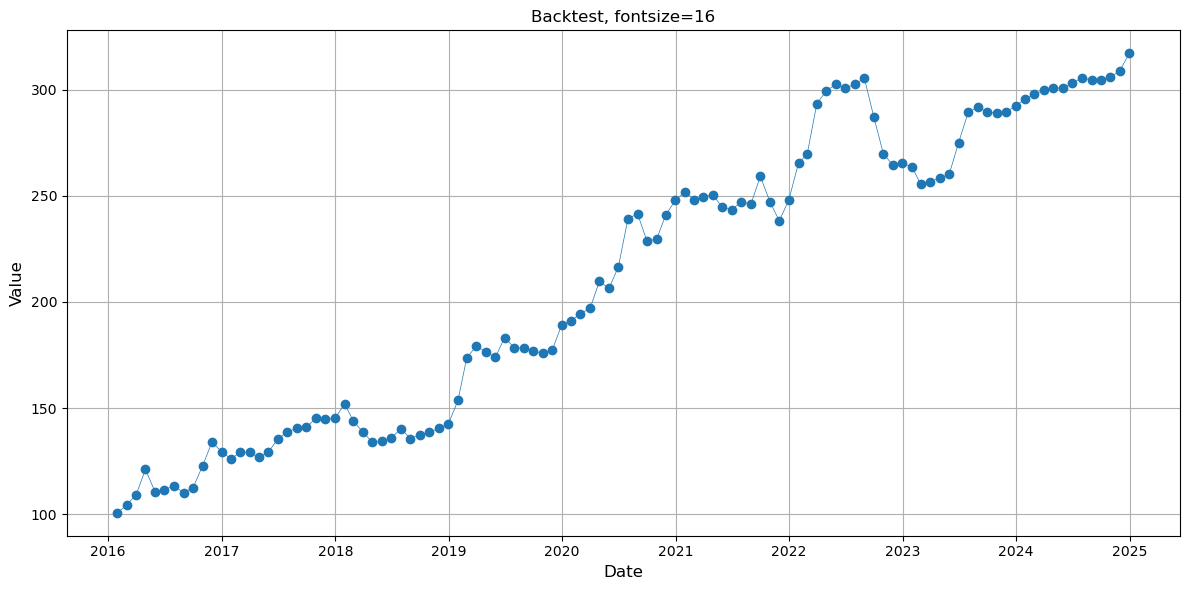

In [58]:
# 绘制数据
plt.figure(figsize=(12, 6))
plt.plot(months, lst, marker='o', linestyle='-', linewidth=0.5, color='tab:blue')
plt.title('Backtest, fontsize=16')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
test = Macrofactor.iloc[108:,]
test = test.apply(lambda x: convolved(x,0.9,12))
test = test.apply(Normalization)
test

,工业增加值,制造业PMI,OECD领先指标,商品房销售面积,社会消费品零售,房地产开发投资,PPI同比,CPI同比,CPI非食品同比,期限利差,信用利差,社融同比,M1同比,M2同比,金融机构贷款余额同比,美元指数,10年期美国国债收益率
Date,,,,,,,,,,,,,,,,,
2024-11-30,-0.162343,0.476283,-1.260622,-1.211208,-1.041241,-0.801784,-1.043498,0.447214,-1.297771,1.188097,1.265983,-1.227881,-1.341551,0.153393,1.264911,-0.452831,-0.500545
2024-12-31,-0.109159,0.109911,-0.640629,-0.938589,-0.390465,-1.336306,0.447214,0.223607,0.324443,0.887979,0.739057,-0.350823,0.747750,1.687323,0.632456,0.362225,-0.229310
2025-01-31,-1.259918,-1.721947,-0.000068,0.580290,-0.111562,0.801784,0.447214,1.118034,1.297771,-0.205064,-0.155627,-0.350823,-0.131956,-0.613572,0.000000,1.155067,1.579114
2025-02-28,1.540859,0.293097,0.640079,0.580290,-0.111562,0.801784,1.192570,-1.565248,-0.648886,-0.874165,-0.683149,0.526235,-0.461845,-0.613572,-1.264911,0.406657,0.224465
2025-03-31,-0.009440,0.842655,1.261240,0.989218,1.654830,0.534522,-1.043498,-0.223607,0.324443,-0.996846,-1.166264,1.403293,1.187602,-0.613572,-0.632456,-1.471118,-1.073725


In [64]:
predictions2 = model.predict(test.values)
predictions2

array([[-6.38559616, -5.03103589, -5.21956481],
       [ 1.27765581,  2.7208069 ,  2.50165348],
       [ 2.76776655,  2.62620927,  1.89219686],
       [ 0.9511423 , -0.29994998, -0.70311701],
       [ 1.3890315 , -0.0160303 ,  1.52883148]])

In [65]:
#最新月表现
test_result = np.argsort(-predictions2) #排名函数：第一列是每行值最小的索引位置，加负号之后，第一列是值最大的每行值最小的索引位置
test_result

array([[1, 2, 0],
       [1, 2, 0],
       [0, 1, 2],
       [0, 1, 2],
       [2, 0, 1]], dtype=int64)